In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/AIML/FruitinAmazon.zip" -d "/content/drive/MyDrive/AIML"

Archive:  /content/drive/MyDrive/AIML/FruitinAmazon.zip
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/acai/images (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/acai/images (16).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/acai/images (3).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/acai/images (4).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/graviola/download (1).

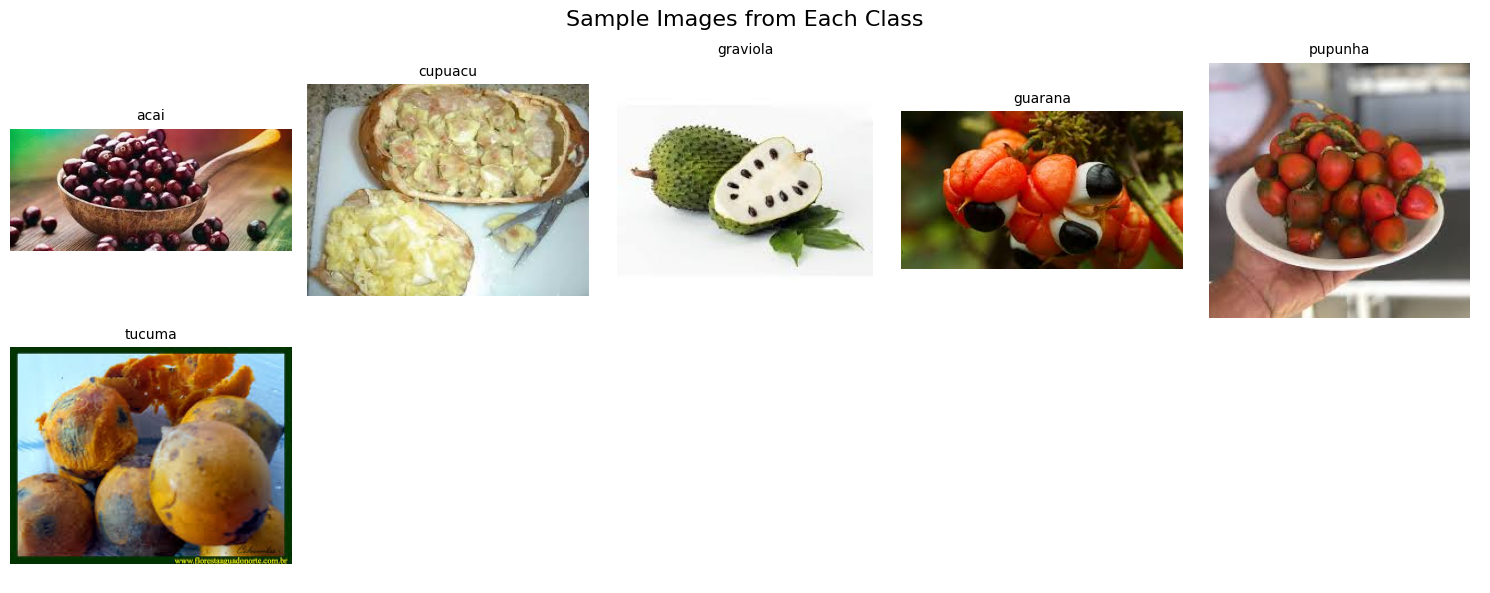

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


What did you Observe?

Each image represents a different class, confirming correct dataset structure.
Images vary in resolution, lighting, and orientation.
Some classes may have fewer images, indicating dataset imbalance.
Preprocessing (resizing, normalization) may be needed for consistency.

In [4]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [5]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'Samip Maharjan.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.2060 - loss: 2.0168
Epoch 1: val_loss improved from inf to 1.01313, saving model to Samip Maharjan.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step - accuracy: 0.1997 - loss: 2.0505 - val_accuracy: 0.8333 - val_loss: 1.0131
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.1042 - loss: 1.9335
Epoch 2: val_loss did not improve from 1.01313
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.1094 - loss: 1.9344 - val_accuracy: 0.6667 - val_loss: 1.4340
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.3391 - loss: 1.5874
Epoch 3: val_loss did not improve from 1.01313
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.3446 - loss: 1.5824 - val_accuracy: 0.0556 - val_loss: 2.2869
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.3160 - loss: 1.7450
Epoch 4: val_loss did not improve from 1.01313
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step - accuracy: 0.3411 - loss: 1.7143 - val_accuracy: 0.5000 - val_loss: 1.2850
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6296 - loss: 1.2287
Epoch 5: val_loss did not improve from 1.01313
3/3 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.7413 - loss: 0.7050 - val_accuracy: 0.6111 - val_loss: 0.8661
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8391 - loss: 0.5253
Epoch 10: val_loss did not improve from 0.86608
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.8446 - loss: 0.5171 - val_accuracy: 0.5556 - val_loss: 0.9853
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8785 - loss: 0.3891
Epoch 11: val_loss improved from 0.86608 to 0.73051, saving model to Samip Maharjan.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - accuracy: 0.8880 - loss: 0.3766 - val_accuracy: 0.8333 - val_loss: 0.7305
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8993 - loss: 0.3053
Epoch 12: val_loss improved from 0.73051 to 0.58851, saving model to Samip Maharjan.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.9036 - loss: 0.2975 - val_accuracy: 0.8333 - val_loss: 0.5885
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 1.0000 - loss: 0.1307
Epoch 13: val_loss improved from 0.58851 to 0.52648, saving model to Samip Maharjan.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 1.0000 - loss: 0.1304 - val_accuracy: 0.8333 - val_loss: 0.5265
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 1.0000 - loss: 0.0842
Epoch 14: val_loss did not improve from 0.52648
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 1.0000 - loss: 0.0831 - val_accuracy: 0.8333 - val_loss: 0.5969
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 1.0000 - loss: 0.0644
Epoch 15: val_loss improved from 0.52648 to 0.35530, saving model to Samip Maharjan.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 845ms/step - accuracy: 1.0000 - loss: 0.0638 - val_accuracy: 0.8889 - val_loss: 0.3553
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 1.0000 - loss: 0.0483
Epoch 16: val_loss did not improve from 0.35530
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 1.0000 - loss: 0.0475 - val_accuracy: 0.8889 - val_loss: 0.4211
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 1.0000 - loss: 0.0270
Epoch 17: val_loss did not improve from 0.35530
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 0.8333 - val_loss: 0.4471
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 1.0000 - loss: 0.0128
Epoch 18: val_loss did not improve from 0.35530
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.8333 - val_loss: 0.4462
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 1.0000 - loss: 0.0098
Epoch 19: val_loss did not improve from 0.35530
3/3 

In [9]:
test_dir = '/content/drive/MyDrive/AIML/FruitinAmazon/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5667 - loss: 200.3326
Test Loss: 200.3325958251953
Test Accuracy: 0.5666666626930237


In [13]:

model.save('Swornim_KC_model.h5')
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.30      0.60      0.40         5
           2       0.62      1.00      0.77         5
           3       0.75      0.60      0.67         5
           4       1.00      0.60      0.75         5
           5       1.00      0.40      0.57         5

    accuracy                           0.63        30
   macro avg       0.78      0.63      0.65        30
weighted avg       0.78      0.63      0.65        30

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 1: val_loss did not improve from 0.35530
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8333 - val_loss: 0.4013
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 2: val_loss did not improve from 0.35530
3/3 ━━━━━━━━━━━━

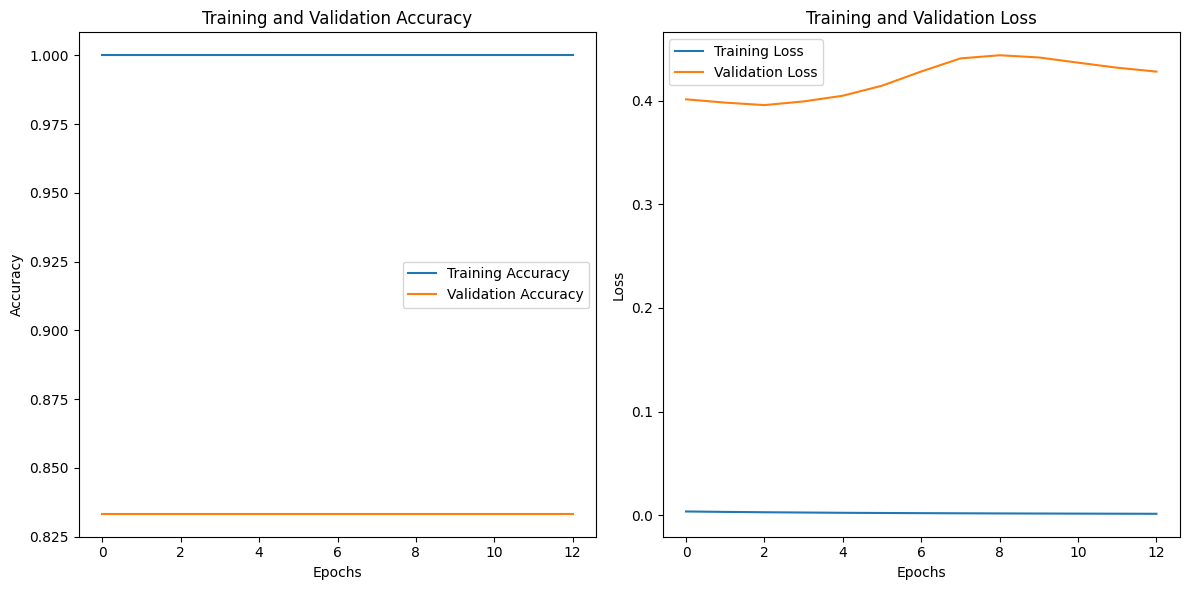

Model saved as 'Swornim_KC_model.h5'


In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('Swornim_KC_model.h5')
print("Model saved as 'Swornim_KC_model.h5'")
